NLP. Домашнее здание №1 (HW).

Николаенко Роман.

# Обработка естественного языка. 
# ДОМАШНЕЕ ЗАДАНИЕ №1

Мы разбили ваш проект на 2 части и предлагаем начать выполнение 1 части. Ниже вы найдете все детали этого задания. Советуем выполнить его прямо сейчас, сохранить ваш jupiter-ноутбук и отправить все три выполненных части проекта на проверку на последней неделе курса.

# ЗАДАЧА
По данным из соревнования:

* Сделайте EDA.
* Придумайте эвристику для предсказания целевого класса. На данном этапе нельзя использовать ML, допускаются исключительно наивные методы.
* Реализуйте один из методов векторизации текста и обучите одну из моделей классического ML для данной задачи. Можно использовать любые библиотеки.
* Предложите метрику, разбейте обучающую выборку на обучающую и валидационную и посчитайте её значение для методов, реализованных в пункте 2 и 3.

In [1]:
# Импортируем необходимые библиотеки

import os
import pickle
import re
import string
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from loguru import logger
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import NLTKWordTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import compute_class_weight

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


nltk.download('wordnet')
nltk.download('omw-1.4')


DATA_FOLDER = os.path.abspath("./data/")
TRAIN_PATH = os.path.join(DATA_FOLDER, "train.csv")
BASELINE_PATH = os.path.join(DATA_FOLDER, "baseline.json")
PALETTE = sns.color_palette("Spectral", 5)
STOPWORDS = nltk.corpus.stopwords.words('english')
ABBREVIATIONS = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# EDA

# 1. Загрузим данные



In [2]:
# Выбираем только нужные столбцы для чтения:

train_df = pd.read_csv(TRAIN_PATH, usecols=["Text", "Sentiment"])
train_df.columns = ["text", "sentiment"]
train_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41154,Airline pilots offering to stock supermarket s...,Neutral
41155,Response to complaint not provided citing COVI...,Extremely Negative
41156,You know itÂs getting tough when @KameronWild...,Positive
41157,Is it wrong that the smell of hand sanitizer i...,Neutral


# 2. Посмотрим информацию датасета

### 2.1. Общее

In [3]:
#  Отобразим информацию о структуре и о типах данных 

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       41158 non-null  object
 1   sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


У нас есть два столбца: один содержит тексты, а другой - оценки этих текстов. В датасете немного более 41 000 строк. 
В столбце с текстами у нас есть один пропуск, а в столбце с оценками уже четыре пропуска. Кажется, что удаление этих пропусков не сильно повлияет на качество модели. Кроме того, мы рассмотрим возможность удаления дубликатов.

In [4]:
# Удалим строки с пропущенными значениями и дубликаты из датафрейма "train_df", затем сбросим индексы строк

train_df = train_df.dropna().reset_index(drop=True)
train_df = train_df.drop_duplicates().reset_index(drop=True)
train_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41150,Airline pilots offering to stock supermarket s...,Neutral
41151,Response to complaint not provided citing COVI...,Extremely Negative
41152,You know itÂs getting tough when @KameronWild...,Positive
41153,Is it wrong that the smell of hand sanitizer i...,Neutral


Теперь мы можем более подробно рассмотреть каждый столбец датасета.

### 2.2. Сентимент

In [5]:
# Удалим строки с отсутствующими значениями и дубликаты в датафрейме train_df, выведем частоты оценок в штуках и в процентах

print(
    "Частоты оценок, в штуках:",
    train_df["sentiment"].value_counts(),
    sep="\n",
    end="\n\n",
)

print(
    "Частоты оценок, в процентах:",
    train_df["sentiment"].value_counts(True).apply(lambda x: (round(x, 3))) * 100,
    sep="\n",
)

Частоты оценок, в штуках:
sentiment
Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

Частоты оценок, в процентах:
sentiment
Positive              27.8
Negative              24.1
Neutral               18.7
Extremely Positive    16.1
Extremely Negative    13.3
Name: proportion, dtype: float64


In [6]:
# Выведем список уникальных значений

train_df["sentiment"].value_counts().index.to_list()

['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']

Позитивных оценок больше всего (примерное 11.4 тыс.), чем негативных (примерное 9.9 тыс.), количество нейтральных оценок немного меньше (7.7 тыс.), затем идут экстремально позитивные (6.6 тыс.) и экстремально негативные (5.5 тыс.). Если сложить обычные и экстремальные оценки, то количество позитивных вновь превысит количество негативных.

In [7]:
# Преобразуем оценки в словарь, рейтинговую шкалу, в которой будут использоваться оценки от 1 до 5

sentiment_dict = {
    "Extremely Positive": 5,
    "Positive": 4,
    "Neutral": 3,
    "Negative": 2,
    "Extremely Negative": 1
}
train_df["sentiment"] = train_df["sentiment"].apply(lambda x: sentiment_dict[x])
train_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",1
...,...,...
41150,Airline pilots offering to stock supermarket s...,3
41151,Response to complaint not provided citing COVI...,1
41152,You know itÂs getting tough when @KameronWild...,4
41153,Is it wrong that the smell of hand sanitizer i...,3


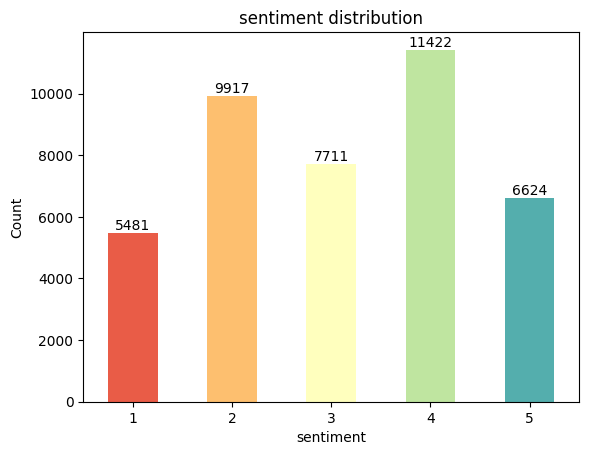

In [8]:
# Отобразим частоту оценок в столбчатой диаграмме

ax = train_df["sentiment"].value_counts().sort_index().plot.bar(
    color=PALETTE,
    title="sentiment distribution",
    rot=0,
)

for bars in ax.containers:
    ax.bar_label(bars)

ax.set_ylabel("Count");

### 2.3. Текст

In [8]:
# Добавим новые текстовые признаки 

def add_text_features(df: pd.DataFrame, column: str = "text") -> pd.DataFrame:
    """Returns new DataFrame with text features from column"""
    df["text_split"] = df[column].apply(lambda x: str(x).lower().strip().split())
    df["text_symbols_n"] = df[column].apply(lambda x: len(str(x)))
    df["text_list_len"] = df["text_split"].apply(lambda x: len(x))
    df["text_set_len"] = df["text_split"].apply(lambda x: len(set(x)))
    return df

In [9]:
# Обработаем и обновим данные

train_df = add_text_features(train_df)
train_df

,text,sentiment,text_split,text_symbols_n,text_list_len,text_set_len
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3,"[@menyrbie, @phil_gahan, @chrisitv, https://t....",111,8,7
1,advice Talk to your neighbours family to excha...,4,"[advice, talk, to, your, neighbours, family, t...",237,38,33
2,Coronavirus Australia: Woolworths to give elde...,4,"[coronavirus, australia:, woolworths, to, give...",131,14,14
3,My food stock is not the only one which is emp...,4,"[my, food, stock, is, not, the, only, one, whi...",306,42,37
4,"Me, ready to go at supermarket during the #COV...",1,"[me,, ready, to, go, at, supermarket, during, ...",310,40,36
...,...,...,...,...,...,...
41150,Airline pilots offering to stock supermarket s...,3,"[airline, pilots, offering, to, stock, superma...",102,12,12
41151,Response to complaint not provided citing COVI...,1,"[response, to, complaint, not, provided, citin...",138,23,22
41152,You know itÂs getting tough when @KameronWild...,4,"[you, know, itâs, getting, tough, when, @kame...",136,18,18
41153,Is it wrong that the smell of hand sanitizer i...,3,"[is, it, wrong, that, the, smell, of, hand, sa...",111,18,16


In [10]:
# Рассмотрим сводные статистические данные о полученных признаках

train_df.describe()

,sentiment,text_symbols_n,text_list_len,text_set_len
count,41155.000000,41155.000000,41155.000000,41155.000000
mean,3.092115,204.197692,30.500255,27.763091
std,1.298687,68.655884,11.591438,9.754834
min,1.000000,11.000000,1.000000,1.000000
25%,2.000000,151.000000,21.000000,20.000000
50%,3.000000,215.000000,32.000000,29.000000
75%,4.000000,259.000000,40.000000,36.000000
max,5.000000,355.000000,64.000000,51.000000


Средний объем текста составляет 204 символа с учетом пробелов и специальных символов. Среднее количество слов равно 30,5, а среднее количество различных слов - 27,8.

# Анализ новых признаков

Отобразим гистограммы для каждого нового признака.

text_symbols_n
255    2297
280     461
279     417
278     375
281     324
       ... 
340       1
334       1
333       1
335       1
12        1
Name: count, Length: 329, dtype: int64

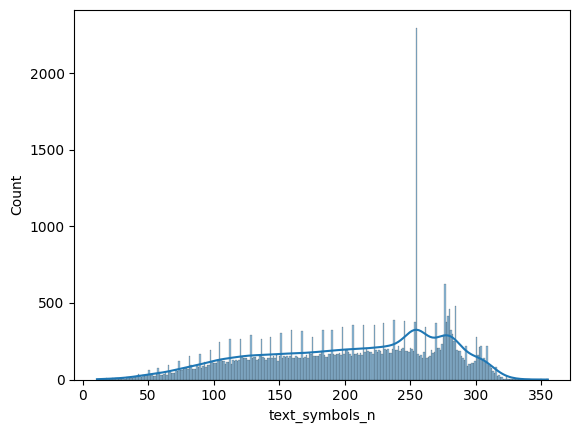

In [11]:
# Длина текста

display(train_df["text_symbols_n"].value_counts())
sns.histplot(train_df["text_symbols_n"], bins=300, kde=True);

Все тексты имеют длину, не превышающую 360 символов. Общее распределение довольно равномерное, однако длина в 255 символов выделяется особенно сильно. 

In [12]:
# Рассмотрим эту длину более подробно

train_df[train_df["text_symbols_n"] == 255]["text"].values[:3]

array(['@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checkout staff to police the actions of the selfish and profiteer',
       '@TheJoshuaTurner @Loreign83 @peanut_astro @my_amigouk @afneil @BorisJohnson @patel4witham This is both disgusting and disgraceful charging over inflated prices for items for stopping the spread of COVID-19, the government really needs to do something abou',
       '@kroger Instead of paid sick leave, @kroger is providing 2 weeks paid leave ONLY to people who test positive for COVID-19 or are placed under mandatory quarantine\r\r\n\r\r\nThis is insufficient to protect staff and the public, especially with little testing av'],
      dtype=object)

Вероятно, это означает ограничение на количество символов в определенной социальной сети "Х". Знаки собачек перед именами пользователей и размер сообщений могут указывать на это.

text_list_len
40    1377
41    1349
37    1341
39    1331
38    1321
      ... 
1        2
61       1
60       1
64       1
62       1
Name: count, Length: 63, dtype: int64

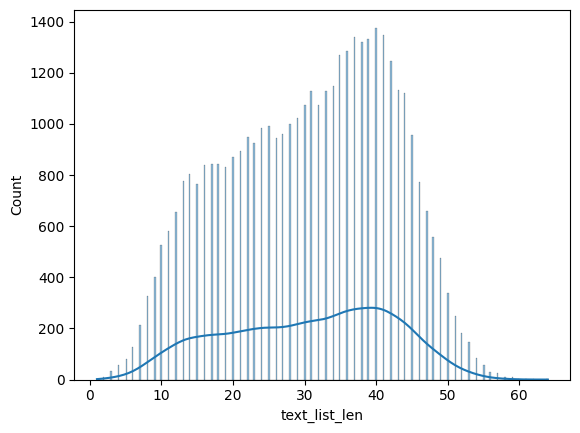

In [13]:
# Количество слов

display(train_df["text_list_len"].value_counts())
sns.histplot(train_df["text_list_len"], bins=300, kde=True);

Отсутствуют значительные выбросы, наибольшее количество текстов содержат около 40 слов.

text_set_len
36    1773
35    1756
34    1635
33    1619
37    1598
Name: count, dtype: int64

text_set_len
1      2
51     4
2     12
50    16
49    25
Name: count, dtype: int64

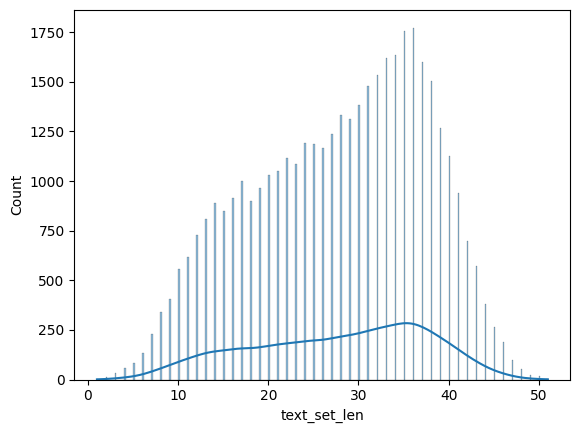

In [14]:
# Число уникальных слов в отзыве

display(train_df["text_set_len"].value_counts().nlargest(5))
display(train_df["text_set_len"].value_counts().nsmallest(5))
sns.histplot(train_df["text_set_len"], bins=300, kde=True);

Заметных выбросов нет и наибольшее количество текстов содержат 36 уникальных слов.

# Сводная таблица по новым признакам



In [15]:
# Создадим сводную таблицу со средними значениями новых признаков в зависимости от оценки:

pivot = pd.pivot_table(
    train_df,
    values=["text_symbols_n", "text_list_len", "text_set_len"],
    index="sentiment"
)
pivot = pivot.apply(lambda x: round(x, 2))
pivot

,text_list_len,text_set_len,text_symbols_n
sentiment,,,
1,34.46,31.03,221.48
2,30.65,27.94,203.33
3,23.14,21.48,168.14
4,30.92,28.16,207.06
5,34.85,31.43,228.24


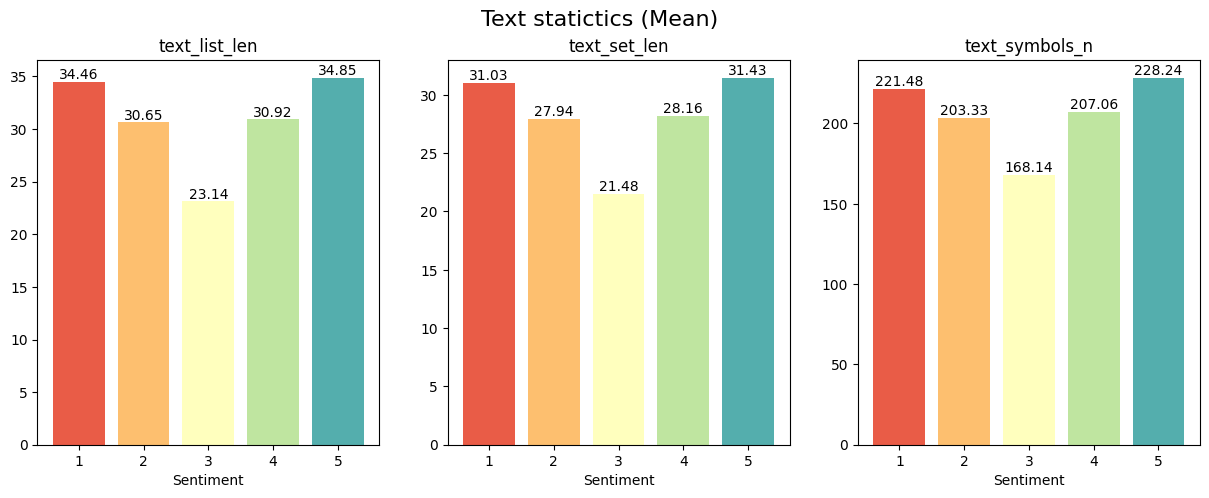

In [16]:
# Визуализируем график столбчатых диаграмм:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Text statictics (Mean)", fontsize=16)

for index, column in enumerate(pivot.columns):
    ax = axs[index]
    ax.bar(
        x=pivot.index,
        height=pivot[column],
        color=PALETTE,
    )
    ax.set_title(column)
    ax.set_xlabel("Sentiment")

    for bars in ax.containers:
        ax.bar_label(bars)

Можно сделать следующие выводы:
- Интересное распределение. В среднем тексты по длине становятся больше с увеличением экстремальности оценки (как позитивных, так и негативных).
- Нейтральные оценки, в целом, имеют самые короткие тексты.
- В среднем, как экстремальные (1 и 5), так и нормальные оценки (2 и 4) имеют примерно одинаковую длину, хотя позитивные тексты немного длиннее, чем негативные.
- Таким образом, можно сделать вывод, что люди склонны писать более длинные отзывы, когда хотят передать более выраженную позитивную или негативную эмоцию.

# Популярные слова



In [17]:
# Соберем все слова в один список и посмотрим на частоту их встречаемости, сложив статистику по частоте встречаемости в табличку:

all_words_list = []
for text_list in train_df["text_split"]:
    all_words_list.extend(text_list)

all_words_series = pd.Series(all_words_list)
text_count_df = pd.DataFrame(all_words_series.value_counts())
text_count_df["word"] = text_count_df.index
text_count_df.index = range(text_count_df.shape[0])
text_count_df = text_count_df[text_count_df.columns.to_list()[::-1]]
text_count_df["len"] = text_count_df["word"].apply(lambda x: len(x))
text_count_df

,word,count,len
0,the,44544,3
1,to,38189,2
2,and,23850,3
3,of,21459,2
4,a,19205,1
...,...,...,...
120796,#inside,1,7
120797,https://t.co/4ayu5ulny9,1,23
120798,https://t.co/7vxyntxoyj,1,23
120799,https://t.co/6kzkuveeih,1,23


In [19]:
# Проведем фильтрацию слов, оставляя только те, длина которых превышает 4 символа, проанализируем, на что были наиболее акцентированы в данных отзывах

text_count_df[text_count_df["len"] > 4].iloc[:30]

,word,count,len
6,#coronavirus,14935,12
15,prices,6654,6
21,grocery,5996,7
23,supermarket,5717,11
25,store,5533,5
26,covid-19,5518,8
28,people,5055,6
30,#covid19,4635,8
36,consumer,4115,8
43,&amp;,3581,5


Итак, большая часть текстов посвящена темам, связанным с COVID-19, онлайн-платформами и нехваткой туалетной бумаги, а также другими интересными аспектами пандемии.

# Выводы:

* Наша работа связана с текстами, связанными с пандемией.
* Когда человек хочет передать сильную эмоцию, он оставляет более длинное сообщение.

# 3. Чистка данных

In [18]:
# Cоздадим дубликат блокнота, который уже был предварительно очищен, и будем дальше работать над его текстовым содержимым с целью улучшений.

train_clean_df = train_df[["text", "sentiment"]].copy()
train_clean_df

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",1
...,...,...
41150,Airline pilots offering to stock supermarket s...,3
41151,Response to complaint not provided citing COVI...,1
41152,You know itÂs getting tough when @KameronWild...,4
41153,Is it wrong that the smell of hand sanitizer i...,3


In [19]:
# Перечислим функции для очистки текстов

def prepare_text(text: str) -> str:
    """Возвращает обработанный текст в нижнем регистре"""
    return text.lower().strip()


def remove_links(text: str) -> str:
    """Удаляет ссылки и не ASCII-символы"""
    text = "".join([x for x in text if x in string.printable])
    # Удаление URL
    text = re.sub(r"http\S+", "", text)
    return text


def remove_emoji(text: str) -> str:
    """Удаляет эмодзи"""
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # эмоций
        u"\U0001F300-\U0001F5FF"  # символов и пиктограмм
        u"\U0001F680-\U0001F6FF"  # символов транспорта и карт
        u"\U0001F1E0-\U0001F1FF"  # флагов (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r"", text)


def remove_punctuations(text: str):
    """Удаляет пунктуации"""
    table = str.maketrans("","",string.punctuation)
    result = text.translate(table)
    return result


def remove_special_characters(text: str) -> str:
    """Удаляет специальные символы и цифры"""
    pattern = r"[^a-zA-z0-9\s]"
    text = re.sub(pattern,"",text)
    text = re.sub(r"[0-9]+", "", text)
    return text


def remove_stopwords(text: str) -> str:
    """Удаляет стоп-слова из текста"""
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in STOPWORDS]
    filtered_text = " ".join(filtered_tokens)    
    return filtered_text


# Аббревиатуры
def _convert_abbrev(word: str) -> str:
    """берет одно слово и заменяет его сокращением, если слово в сокращениях dict"""
    return ABBREVIATIONS[word.lower()] if word.lower() in ABBREVIATIONS.keys() else word


def convert_abbrev_in_text(text: str) -> str:
    """Заменяет все сокращения в тексте"""
    tokenizer = NLTKWordTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [_convert_abbrev(word) for word in tokens]
    text = " ".join(tokens)
    return text


# Denoise text
def _strip_html(text: str) -> str:
    """удаляет текст как HTML"""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def _remove_between_square_brackets(text: str) -> str:
    """удалить символы в квадратных скобках"""
    return re.sub(r"\[[^\]]*\]", "", text)


def denoise_text(text: str) -> str:
    """Удаляет текст в формате HTML и удаляет символы между квадратными скобками"""
    text = _strip_html(text)
    text = _remove_between_square_brackets(text) 
    return text


# Очистить текстовый конвейер
def clean_text_pipeline(text: str) -> str:
    """Очищает входной текст и возвращает очищенный"""
    text = prepare_text(text)
    text = remove_links(text)
    text = remove_emoji(text)
    text = remove_stopwords(text)
    text = remove_punctuations(text)
    text = convert_abbrev_in_text(text)
    text = denoise_text(text)
    text = remove_special_characters(text)
    return text


# Вывести и лемматизировать
def stem_text(text):
    """Получает входной текст и возвращает окончательный вариант"""
    stemmer = SnowballStemmer(language="english")
    return " ".join([stemmer.stem(word) for word in text.split()])


def lemmatize_text(text):
    """Получает входной текст и возвращает лемматизированный текст"""
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [20]:
# Мы можем использовать эту функцию и ввести числовые характеристики для текста, который был очищен

TEXT_CLEAN_COLUMN = "text_clean"
train_clean_df[TEXT_CLEAN_COLUMN] = train_clean_df["text"].apply(clean_text_pipeline)
train_clean_df['text_stemmer'] = train_clean_df[TEXT_CLEAN_COLUMN].apply(stem_text)
train_clean_df['text_lemma'] = train_clean_df[TEXT_CLEAN_COLUMN].apply(lemmatize_text)
train_clean_df = add_text_features(train_clean_df, TEXT_CLEAN_COLUMN)
train_clean_df

,text,sentiment,text_clean,text_stemmer,text_lemma,text_split,text_symbols_n,text_list_len,text_set_len
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3,menyrbie philgahan chrisitv,menyrbi philgahan chrisitv,menyrbie philgahan chrisitv,"[menyrbie, philgahan, chrisitv]",27,3,3
1,advice Talk to your neighbours family to excha...,4,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p...",196,27,24
2,Coronavirus Australia: Woolworths to give elde...,4,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elder dis...,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld...",99,12,12
3,My food stock is not the only one which is emp...,4,food stock one empty please nt panic enough fo...,food stock one empti pleas nt panic enough foo...,food stock one empty please nt panic enough fo...,"[food, stock, one, empty, please, nt, panic, e...",170,23,20
4,"Me, ready to go at supermarket during the #COV...",1,ready go supermarket covid outbreak m paranoid...,readi go supermarket covid outbreak m paranoid...,ready go supermarket covid outbreak m paranoid...,"[ready, go, supermarket, covid, outbreak, m, p...",187,23,23
...,...,...,...,...,...,...,...,...,...
41150,Airline pilots offering to stock supermarket s...,3,airline pilots offering stock supermarket shel...,airlin pilot offer stock supermarket shelv nz ...,airline pilot offering stock supermarket shelf...,"[airline, pilots, offering, stock, supermarket...",67,9,9
41151,Response to complaint not provided citing COVI...,1,response complaint provided citing covid relat...,respons complaint provid cite covid relat dela...,response complaint provided citing covid relat...,"[response, complaint, provided, citing, covid,...",108,16,16
41152,You know itÂs getting tough when @KameronWild...,4,know getting tough kameronwilds rationing toil...,know get tough kameronwild ration toilet paper...,know getting tough kameronwilds rationing toil...,"[know, getting, tough, kameronwilds, rationing...",106,13,13
41153,Is it wrong that the smell of hand sanitizer i...,3,wrong smell hand sanitizer starting turn coron...,wrong smell hand sanit start turn coronavirus ...,wrong smell hand sanitizer starting turn coron...,"[wrong, smell, hand, sanitizer, starting, turn...",70,9,8


Посмотрим на статистики по числовым фичам в зависимости от оценки после очистки:

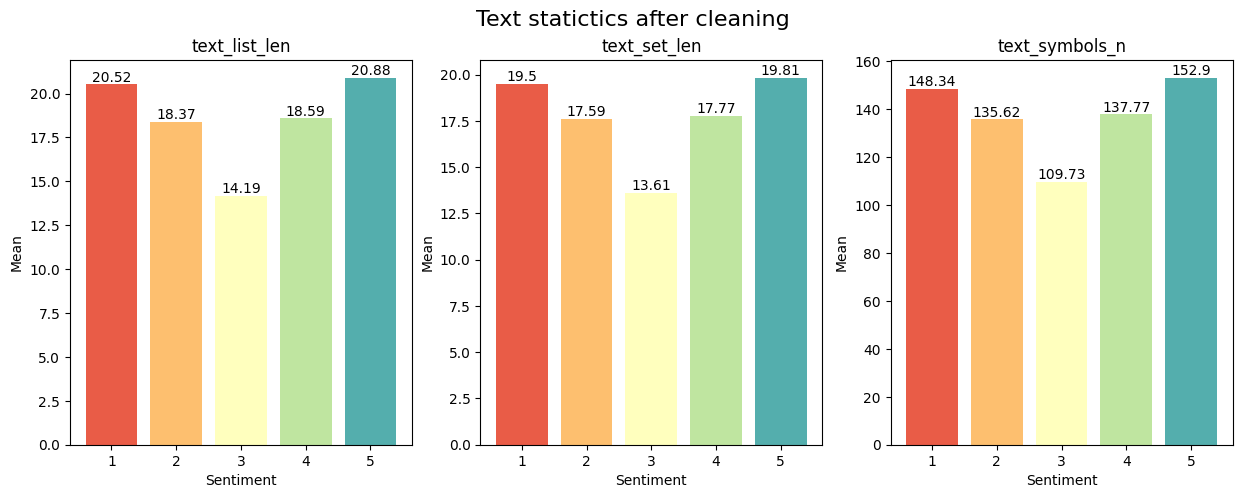

In [21]:
# Проанализируем числовые характеристики для очищенного текста в зависимости от его оценки

TEXT_NUM_COLUMNS = ["text_symbols_n", "text_list_len", "text_set_len"]

pivot_clean = pd.pivot_table(
    train_clean_df,
    values=TEXT_NUM_COLUMNS,
    index="sentiment"
)
pivot_clean = pivot_clean.apply(lambda x: round(x, 2))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Text statictics after cleaning", fontsize=16)

for index, column in enumerate(pivot_clean.columns):
    ax: plt.Axes = axs[index]
    ax.bar(
        x=pivot_clean.index,
        height=pivot_clean[column],
        color=PALETTE,
    )
    ax.set_title(column)
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Mean")

    for bars in ax.containers:
        ax.bar_label(bars)

После процесса очистки, мы можем наблюдать, что средние значения числовых характеристик снизились и это изменение произошло пропорционально. При этом, отношения между разными оценками остались примерно такими же.

,text_symbols_n,text_list_len,text_set_len
mean,135.840238,18.340323,17.507423
std,49.509604,6.788707,6.297817
min,0.000000,0.000000,0.000000
25%,97.000000,13.000000,13.000000
50%,142.000000,19.000000,18.000000
75%,175.000000,24.000000,22.000000
max,284.000000,42.000000,38.000000


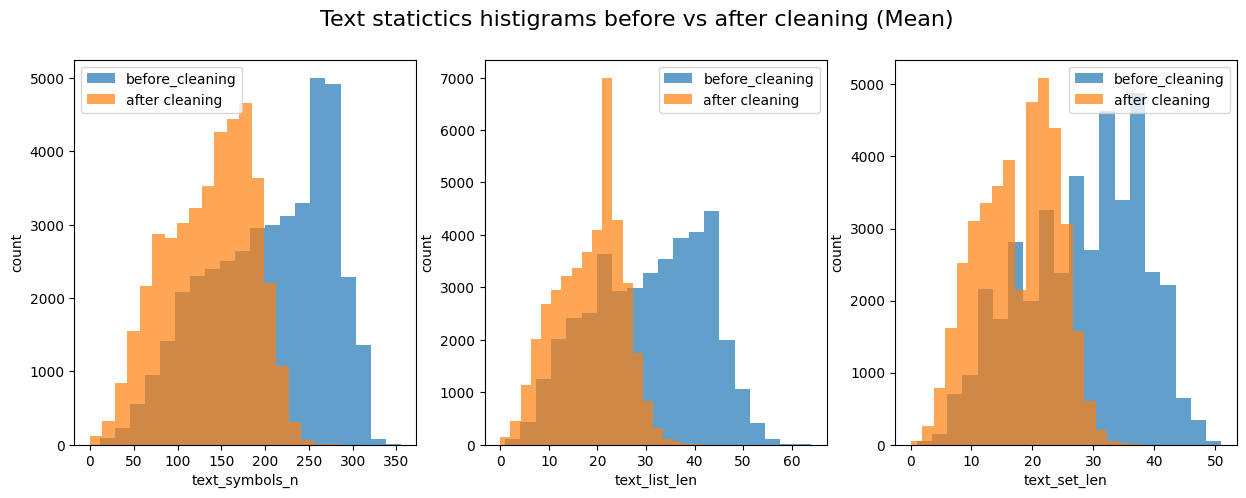

In [22]:
# Посмотрим на гистограммы, чтобы более подробно изучить числовые признаки после очистки

display(train_clean_df.describe().iloc[1:,1:])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Text statictics histigrams before vs after cleaning (Mean)", fontsize=16)
for index, column in enumerate(TEXT_NUM_COLUMNS):
    ax: plt.Axes = axs[index]
    for df, status in zip(
        [
            train_df,
            train_clean_df,
        ],
        [
            "before_cleaning",
            "after cleaning",
        ],
    ):
        ax.hist(
            x=df[column],
            label=status,
            bins=20,
            alpha=0.7,
        )
    ax.set_xlabel(column)
    ax.set_ylabel("count")
    ax.legend()

Заметно, что после очистки текст потерял много символов и слов. Теперь мы можем приступить к построению моделей и предсказанию классов.

# Моделирование


In [ ]:
# Разделение на train-test

X = train_clean_df
y = train_clean_df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)
X_train_with_y: pd.DataFrame = X_train
X_test_with_y: pd.DataFrame = X_test
X_train: pd.DataFrame = X_train.drop(columns=["sentiment"]) 
X_test: pd.DataFrame = X_test.drop(columns=["sentiment"]) 
y_train = y_train
y_test = y_test

## 1. Baseline
Для предсказания целевого класса без использования ML можно воспользоваться эвристикой, основанной на определенных правилах или методах. В данном случае предлагается использовать наивный подход.
Можно выбрать accuracy в качестве метрики, которая показывает процент правильно угаданных классов.

In [ ]:
# Для сохранения результатов предсказаний можно создать дополнительный датафрейм с оценками

evaluate_df = pd.DataFrame(columns=["method", "accuracy"], index=range(1))
evaluate_df

,method,accuracy
0,NaN,NaN


# 1.1. Random



In [ ]:
# Попробуем Random Choise:

baseline_df = X_test_with_y.copy()

METHOD = "random"
INDEX = 0
baseline_df[METHOD] = np.random.choice(range(1, 6), size=baseline_df.shape[0])
accuracy = accuracy_score(baseline_df["sentiment"].values, baseline_df[METHOD].values)

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.200219


Точность около 20%.

# 1.2. Самый популярный класс

Если мы предскажем все тексты как принадлежащие самому популярному классу (4 - "хорошо"), то точность предсказания составит 28% (поскольку этот класс составляет 28% от общего числа классов в выборке):

In [ ]:
# Используем наивный метод для предсказания классов текстов


METHOD = "most_popular"
INDEX = 1
baseline_df[METHOD] = 4
accuracy = accuracy_score(baseline_df["sentiment"].values, baseline_df[METHOD].values)

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.200219
1,most_popular,0.279917


# 1.3. Эвристика по распространенности конкретных слов

Мы можем попытаться использовать следующий алгоритм:

1. Для каждой оценки в тренировочной выборке создадим набор уникальных слов.
2. Удалим из каждого набора слова, которые присутствуют во всех пяти наборах.
3. Затем просмотрим каждый текст из тестовой выборки и подсчитаем, сколько слов из этого текста встречается в наборе уникальных слов для каждой оценки.
4. Если для определенной оценки есть только одна максимальная частота слов, устанавливаем соответствующую оценку. В случае, если такая максимальная частота не является единственной, устанавливаем наиболее популярную оценку - 4.

In [ ]:
# Создадим наборы уникальных слов


stats_dfs_list = []
for sentiment in range(1, 6):
    all_words_list = []
    for text_list in X_train_with_y[X_train_with_y["sentiment"] == sentiment]["text_split"]:
        all_words_list.extend(text_list)
    all_words_series = pd.Series(all_words_list)
    clean_text_count_df = pd.DataFrame(all_words_series.value_counts())
    clean_text_count_df["word"] = clean_text_count_df.index
    clean_text_count_df.index = range(clean_text_count_df.shape[0])
    clean_text_count_df = clean_text_count_df[clean_text_count_df.columns.to_list()[::-1]]
    clean_text_count_df["len"] = clean_text_count_df["word"].apply(lambda x: len(x))
    stats_dfs_list.append(clean_text_count_df)
sets_list = []
for index in range(5):
    sets_list.append(set(stats_dfs_list[index]["word"].values))
union = set.intersection(*sets_list)
unique_words_lists = [sorted(words - union) for words in sets_list]

# Проверим тексты в тестовой выборке
df_slice = X_test_with_y[["text_split", "sentiment"]].values
logger.info(f"df rows number: {df_slice.shape[0]}")
clf_dict = {}
initial_sentiment_list = [0 for _ in range(5)]
sentiments_list = sorted(X_test_with_y["sentiment"].unique())
logger.debug("Main loop start")
for index, (text, sentiment) in enumerate(df_slice):
    clf_dict.update(
        {
            index: {
                "sentiment": sentiment,
                "evaluation": initial_sentiment_list.copy(),
                "sentiment_pred": 4,
            }
        }
    )
    for word in text:
        for i, unique_words in enumerate(unique_words_lists):
            if word in unique_words:
                clf_dict[index]["evaluation"][i] += 1

    evaluation: list = clf_dict[index]["evaluation"]
    max_words: int = max(evaluation)
    max_words_count = evaluation.count(max_words)
    if max_words_count == 1:
        clf_dict[index]["sentiment_pred"] = evaluation.index(max_words) + 1
    if ((index != 0) and ((index) % 2000 == 0)) or (index == df_slice.shape[0] - 1):
        counter = 0
        for dct in clf_dict.values():
            if dct["sentiment"] == dct["sentiment_pred"]:
                counter += 1
        logger.info(f"Text index = {index}, accuracy = {round(counter / len(clf_dict), 3)}")
logger.debug("Main loop end")

accuracy = counter / len(clf_dict)

2023-12-19 20:12:15.355 | INFO     | __main__:<module>:22 - df rows number: 8231
2023-12-19 20:12:15.356 | DEBUG    | __main__:<module>:26 - Main loop start
2023-12-19 20:13:02.453 | INFO     | __main__:<module>:52 - Text index = 2000, accuracy = 0.316
2023-12-19 20:13:43.964 | INFO     | __main__:<module>:52 - Text index = 4000, accuracy = 0.309
2023-12-19 20:14:24.698 | INFO     | __main__:<module>:52 - Text index = 6000, accuracy = 0.304
2023-12-19 20:15:04.408 | INFO     | __main__:<module>:52 - Text index = 8000, accuracy = 0.302
2023-12-19 20:15:09.000 | INFO     | __main__:<module>:52 - Text index = 8230, accuracy = 0.302
2023-12-19 20:15:09.001 | DEBUG    | __main__:<module>:53 - Main loop end


In [ ]:
# Если нужно посмотреть результаты, но предыдущая ячейка не была запущена


counter = 2483
len_clf_dict = 8231
accuracy = counter / len_clf_dict

In [ ]:
# Добавим в датафрейм evaluate_df информацию о методе и его точности для указанного индекса.


METHOD = "unique_words"
INDEX = 2

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.200219
1,most_popular,0.279917
2,unique_words,0.301664


Теперь мы улучшили результаты, достигнув точности около 30%. Однако это улучшение незначительно по сравнению с самым популярным классом, и алгоритм работает очень медленно (8 тысяч результатов за почти 3 минуты).

Однако, если мы применим этот алгоритм к целевой переменной, выделенной из уникальных слов всего набора текстов, мы получим значительно лучшие результаты. Точность в этом случае достигает 63%. Логи работы алгоритма.

```log
2023-12-11 11:55:26.414 | INFO     | __main__:<module>:2 - df rows number: 41155
2023-12-11 11:55:26.416 | DEBUG    | __main__:<module>:7 - Main loop start
2023-12-11 11:56:09.577 | INFO     | __main__:<module>:33 - Text index = 2000, accuracy = 0.617
2023-12-11 11:56:47.884 | INFO     | __main__:<module>:33 - Text index = 4000, accuracy = 0.617
2023-12-11 11:57:28.774 | INFO     | __main__:<module>:33 - Text index = 6000, accuracy = 0.616
2023-12-11 11:58:06.607 | INFO     | __main__:<module>:33 - Text index = 8000, accuracy = 0.621
2023-12-11 11:58:42.085 | INFO     | __main__:<module>:33 - Text index = 10000, accuracy = 0.62
2023-12-11 11:59:19.709 | INFO     | __main__:<module>:33 - Text index = 12000, accuracy = 0.623
2023-12-11 11:59:56.141 | INFO     | __main__:<module>:33 - Text index = 14000, accuracy = 0.622
2023-12-11 12:00:33.923 | INFO     | __main__:<module>:33 - Text index = 16000, accuracy = 0.626
2023-12-11 12:01:09.220 | INFO     | __main__:<module>:33 - Text index = 18000, accuracy = 0.628
2023-12-11 12:01:45.349 | INFO     | __main__:<module>:33 - Text index = 20000, accuracy = 0.63
```

Вывод: Алгоритм, который использует уникальные слова для каждого класса, показывает немного лучшую производительность, чем самый популярный класс, но не обладает надежной предсказательной силой и требует значительных временных затрат. Однако, данный алгоритм может быть использован в качестве базовой оценки.

# 2. Векторизация и классические ML-алгоритмы


In [ ]:
# Проведем векторизацию и предварительную обработку данных

vectorizer = CountVectorizer()

vec_train = vectorizer.fit_transform(X_train["text_clean"]).toarray()
vec_test = vectorizer.transform(X_test["text_clean"]).toarray()

In [ ]:
# Предложим внести числовые данные о статистике очищенного текста в новые столбцы

vec_train = np.hstack([vec_train, X_train[X_train.columns[-3:]].values])
vec_test = np.hstack([vec_test, X_test[X_test.columns[-3:]].values])

In [ ]:
# Сохраняем веса классов:

y_classes = X_train_with_y["sentiment"].unique()
weights = compute_class_weight(
    class_weight='balanced',
    classes=y_classes,
    y=y_train
)
class_weights = {_class: weight for _class, weight in zip(y_classes, weights)}
class_weights

{3: 1.0653292347516583,
 2: 0.8291110551498363,
 4: 0.7221759157710024,
 5: 1.247121212121212,
 1: 1.495525777878719}

# 2.1. MultinomialNB

Опробуем основную модель машинного обучения - наивный Байесовский классификатор.

In [ ]:
# Константы


METHOD = "multinomial_naive_bayes"
INDEX = 3
MODEL_PATH = f"./models/{METHOD}.pcl"

In [ ]:
# Если модель ещё не готова

model = MultinomialNB()
model.fit(vec_train, y_train)
y_pred = model.predict(vec_test)
accuracy = accuracy_score(y_pred, y_test)
with open(MODEL_PATH, "wb") as file:
    pickle.dump(model, file)

In [ ]:
# Если модель уже готова


with open(MODEL_PATH, "rb") as file:
    model: MultinomialNB() = pickle.load(file)
    y_pred = model.predict(vec_test)
    accuracy = accuracy_score(y_pred, y_test)

In [ ]:
# Запишем результат в табличку


evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.200219
1,most_popular,0.279917
2,unique_words,0.301664
3,multinomial_naive_bayes,0.443203


Таким образом, можно сказать, что результаты значительно улучшились. Наивный Байесовский классификатор дал точность в 44%, что является заметным прогрессом по сравнению с другими методами.

# 2.2. RandomForestClassifier

Попробуем случайный лес.

In [ ]:
# Константы


METHOD = "random_forest_classifier"
INDEX = 4
MODEL_PATH = f"./models/{METHOD}.pcl"

In [ ]:
# Если модель ещё не готова 


model = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,
    warm_start=True,
    n_jobs=-1,
)
model.fit(vec_train, y_train)
y_pred = model.predict(vec_test)
accuracy = accuracy_score(y_pred, y_test)
with open(MODEL_PATH, "wb") as file:
    pickle.dump(model, file)

In [ ]:
# Если модель уже готова


with open(MODEL_PATH, "rb") as file:
    model: RandomForestClassifier() = pickle.load(file)
    y_pred = model.predict(vec_test)
    accuracy = accuracy_score(y_pred, y_test)

In [ ]:
# Запишем результат в табличку

evaluate_df.loc[INDEX, "method"] = METHOD
evaluate_df.loc[INDEX, "accuracy"] = accuracy
evaluate_df

,method,accuracy
0,random,0.200219
1,most_popular,0.279917
2,unique_words,0.301664
3,multinomial_naive_bayes,0.443203
4,random_forest_classifier,0.526303


Хотя использование случайного леса привело к незначительному улучшению результатов, его эффект оказался менее 10 процентных пунктов в сравнении с использованием наивного Байеса. Кроме того, время расчета для случайного леса было в 30 раз больше (2 минуты по сравнению с 1 часом). Учитывая уже достигнутую точность более 50%, мы больше не будем пробовать другие модели.

# Вывод

Мы провели анализ 41 тысячи текстов, чтобы оценить их настроение по шкале от 1 до 5. В результате получили следующие результаты:
1. Мы исследовали твиты, связанные с Covid-19.
2. Более выраженное настроение соответствовало более длинным текстам как с позитивными, так и с негативными оценками. Нейтральные тексты были самыми короткими.
3. Процесс очистки текстов значительно сокращал их размеры (спасибо за это, кэп).

Мы рассмотрели 5 моделей для прогнозирования настроения текстов:
1. Три неоснованных на машинном обучении модели:
  - Случайный выбор (точность 20% - мгновенный результат)
  - Оценка самым часто встречающимся классом (точность 28% - мгновенный результат)
  - Эвристическая оценка на основе частоты использования уникальных слов для каждого класса (точность 30% - 8 тысяч текстов за 3 минуты)
2. Две классические модели машинного обучения:
  - MultinomialNB (точность 44% - 8 тысяч текстов за 2 минуты)
  - RandomForestClassifier (точность 53% - 8 тысяч текстов за 60 минут)

In [ ]:
# Запишем обработанные наборы данных

evaluate_df.to_csv("./data/evaluate.csv", index=False)
X_train_with_y.to_csv("./data/X_train_with_y.csv", index=False)
X_test_with_y.to_csv("./data/X_test_with_y.csv", index=False)